In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 1: Import Dataset, and Text Cleansing

In [2]:
import pandas as pd
import re

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/DSC25/PlatinumChallenge/clean.csv')

# Drop rows with missing values
df.dropna(subset=['Text_Bersih', 'Sentiment'], inplace=True)

# Define text cleansing function
def cleansing_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s!?]', '', text)  # Remove special characters except '!?'
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    return text

# Apply cleansing function
df['Text_Bersih'] = df['Text_Bersih'].apply(cleansing_text)

# Display dataset info
print(df.info())
print(df['Text_Bersih'].head())

# Memeriksa ukuran (dimensi) dari DataFrame (jumlah baris dan kolom)
df.shape

# Menghitung jumlah kemunculan setiap nilai unik dalam kolom Sentiment dari DataFrame
df['Sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 10928 entries, 0 to 10932
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   10928 non-null  int64 
 1   Text         10928 non-null  object
 2   Text_Bersih  10928 non-null  object
 3   Sentiment    10928 non-null  object
dtypes: int64(1), object(3)
memory usage: 426.9+ KB
None
0    warung ini dimiliki oleh pengusaha pabrik tahu...
1    mohon ulama lurus dan k mmbri hujjah pak ai ap...
2    lokasi strategis di jalan sumatra bandung temp...
3    betapa bahagia nya diri ini saat unboxing pake...
4    aduh jadi mahasiswa jangan sombong dong kasih ...
Name: Text_Bersih, dtype: object


,count
Sentiment,
positive,6383
negative,3407
neutral,1138


Step 2: Normalize Slang Using new_kamusalay.csv

In [3]:
# Load slang dictionary
kamus_alay = pd.read_csv('/content/drive/MyDrive/DSC25/PlatinumChallenge/new_kamusalay.csv', header=None, index_col=0, encoding='latin-1').squeeze(axis=1).to_dict()

# Define function to normalize slang
def normalize_slang(text):
    words = text.split()
    normalized_words = [kamus_alay.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Define function to normalize slang if needed
def normalize_slang_if_needed(text):
    if isinstance(text, str) and any(word in kamus_alay for word in text.split()):
        return normalize_slang(text)
    return text

# Apply normalization
df['Text_Bersih'] = df['Text_Bersih'].apply(normalize_slang_if_needed)

# Display results
print(df['Text_Bersih'].head())


0    warung ini dimiliki oleh pengusaha pabrik tahu...
1    mohon ulama lurus dan k mmbri hujjah pak ai ap...
2    lokasi strategis di jalan sumatra bandung temp...
3    betapa bahagia nya diri ini saat unboxing pake...
4    aduh jadi mahasiswa jangan sombong dong kasih ...
Name: Text_Bersih, dtype: object


Step 3: Handle Abusive Words Using abusive.csv

In [4]:
# Load abusive words
abusive_words = set(pd.read_csv('/content/drive/MyDrive/DSC25/PlatinumChallenge/abusive.csv', header=None)[0].tolist())

# Define function to handle abusive words
def handle_abusive_words(text, replacement=''):
    words = text.split()
    handled_words = [replacement if word in abusive_words else word for word in words]
    return ' '.join(handled_words)

# Define function to handle abusive words
def handle_abusive_words_if_needed(text, replacement=''):
    if isinstance(text, str) and any(word in abusive_words for word in text.split()):
        return handle_abusive_words(text, replacement)
    return text

# Apply abusive word handling
df['Text_Bersih'] = df['Text_Bersih'].apply(lambda x: handle_abusive_words_if_needed(x, replacement=''))

# Display results
print(df['Text_Bersih'].head())

0    warung ini dimiliki oleh pengusaha pabrik tahu...
1    mohon ulama lurus dan k mmbri hujjah pak ai ap...
2    lokasi strategis di jalan sumatra bandung temp...
3    betapa bahagia nya diri ini saat unboxing pake...
4    aduh jadi mahasiswa jangan sombong dong kasih ...
Name: Text_Bersih, dtype: object


Step 4: Remove Stopwords and Synonym Replacement for Augmentation

In [5]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import random

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

# Define stopwords
stop_words = set(stopwords.words('indonesian'))

# Define function to remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply stopword removal
df['Text_Bersih'] = df['Text_Bersih'].apply(remove_stopwords)

# Define synonym replacement function for augmentation
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(sentence, n=1):
    words = sentence.split()
    random_words = list(set(words))
    random.shuffle(random_words)
    num_replaced = 0
    for random_word in random_words:
        synonyms = get_synonyms(random_word)
        if synonyms:
            synonym = random.choice(synonyms)
            words = [synonym if word == random_word else word for word in words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(words)

# Apply augmentation
augmented_texts = []
augmented_labels = []

for text, label in zip(df['Text_Bersih'], df['Sentiment']):
    augmented_texts.append(text)
    augmented_labels.append(label)
    augmented_text = synonym_replacement(text, n=1)
    if augmented_text != text:
        augmented_texts.append(augmented_text)
        augmented_labels.append(label)

# Create new DataFrame for augmented data
augmented_df = pd.DataFrame({
    'Text_Bersih': augmented_texts,
    'Sentiment': augmented_labels
})


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Step 5: Encode Labels

In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
augmented_df['Encoded_Sentiment'] = label_encoder.fit_transform(augmented_df['Sentiment'])

# Simpan hasil encoding ke file .npy
np.save('/content/drive/MyDrive/DSC25/PlatinumChallenge/classes.npy', label_encoder.classes_)

# Display results
print(augmented_df.head())


                                         Text_Bersih Sentiment  \
0  warung dimiliki pengusaha pabrik puluhan terke...  positive   
1  warung dimiliki pengusaha pabrik puluhan terke...  positive   
2  mohon ulama lurus k mmbri hujjah ai diwlh suar...   neutral   
3  mohon ulama lurus atomic_number_19 mmbri hujja...   neutral   
4  lokasi strategis jalan sumatra bandung nya nya...  positive   

   Encoded_Sentiment  
0                  2  
1                  2  
2                  1  
3                  1  
4                  2  


Step 6: Analisis Frekuensi Kata untuk Menentukan num_words

In [7]:
from collections import Counter

# Gabungkan semua teks menjadi satu string besar
all_text = ' '.join(df['Text_Bersih'].astype(str).tolist())

# Pisahkan string menjadi daftar kata
all_words = all_text.split()

# Hitung frekuensi setiap kata
word_freq = Counter(all_words)

# Urutkan kata berdasarkan frekuensi kemunculan
most_common_words = word_freq.most_common()

# Hitung total kata
total_words = sum(word_freq.values())

# Tentukan jumlah kata yang mencakup 95% dari total frekuensi
cumulative_freq = 0
num_words = 0
for word, freq in most_common_words:
    cumulative_freq += freq
    num_words += 1
    if cumulative_freq / total_words >= 0.95:
        break

print(f"Jumlah kata yang mencakup 95% dari total frekuensi: {num_words}")

Jumlah kata yang mencakup 95% dari total frekuensi: 7156


Step 7: Analisis Panjang Kalimat untuk Menentukan max_sequence_length

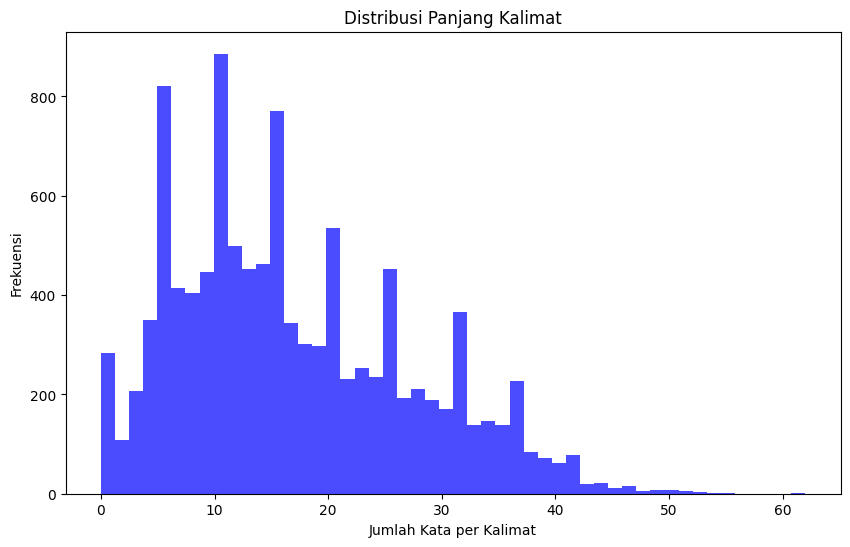

Panjang maksimum urutan yang mencakup 95% dari kalimat: 36


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Hitung panjang setiap kalimat dalam jumlah kata
sentence_lengths = [len(sentence.split()) for sentence in df['Text_Bersih'].astype(str).tolist()]

# Plot distribusi panjang kalimat
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Distribusi Panjang Kalimat')
plt.xlabel('Jumlah Kata per Kalimat')
plt.ylabel('Frekuensi')
plt.show()

# Tentukan panjang maksimum yang mencakup 95% dari kalimat
max_sequence_length = int(np.percentile(sentence_lengths, 95))
print(f"Panjang maksimum urutan yang mencakup 95% dari kalimat: {max_sequence_length}")

Step 8: Tokenize and Pad Sequences

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize tokenizer
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')

# Fit tokenizer on text
tokenizer.fit_on_texts(augmented_df['Text_Bersih'])

# Convert texts to sequences and pad them
sequences = tokenizer.texts_to_sequences(augmented_df['Text_Bersih'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Display results
print(padded_sequences[:5])

[[ 133 2128 3327 3108 1008  129  382    7  606 1565 5566 1255 1565    1
   133  180    8  230 1954  140    8   13   23   17  211   24    6   66
   644    1    2  318  281    1    0    0]
 [ 133 2128 3327 3108 1008  129  382    7  606 1565 5566 1255 1565    1
   133  180    8  230 1954  140    8   13   23   17  211   24    6   66
   644    1    2  318  281    1    0    0]
 [ 701  887 2903  635    1    1  216    1  326  117    1    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [ 701  887 2903  558  529    1    1    1  216    1  326  117    1    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  34  144   15 1026    7    2   14 1101  155    1    2    4   37  455
   139  761  124 6970    2  292    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


Step 9: Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    augmented_df['Encoded_Sentiment'],
    test_size=0.2,
    random_state=42
)

Step 10: Build and Train LSTM Model

In [29]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

#Compute Class Weights
y_train_np = y_train.to_numpy().astype(int)

# Calculate class weights using compute_class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                        classes=np.unique(y_train_np),
                                        y=y_train_np)

class_weights_dict = dict(enumerate(class_weights))

# Gunakan embedding FastText
embedding_index = {}
with open('/content/drive/MyDrive/DSC25/PlatinumChallenge/cc.id.300.vec', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create embedding matrix
embedding_dim = 300  # Sesuai dengan dimensi FastText yang digunakan
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5)) # Meningkatkan Dropout untuk regularisasi
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5)) # Tambahkan Dropout setelah layer kedua
model.add(Dense(3, activation='softmax'))

# Mengompilasi model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

y_train = y_train.reset_index(drop=True)

# Melatih model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,  # Tetap gunakan jumlah epoch besar, EarlyStopping akan menghentikan lebih awal
                    batch_size=64,  # Kurangi batch size tidak apa-apa
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 74s 362ms/step - accuracy: 0.6167 - loss: 0.9891 - val_accuracy: 0.7380 - val_loss: 0.6109 - learning_rate: 1.0000e-04
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 360ms/step - accuracy: 0.7393 - loss: 0.6536 - val_accuracy: 0.7904 - val_loss: 0.5286 - learning_rate: 1.0000e-04
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - accuracy: 0.7896 - loss: 0.5447 - val_accuracy: 0.7961 - val_loss: 0.5296 - learning_rate: 1.0000e-04
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 359ms/step - accuracy: 0.8136 - loss: 0.5028 - val_accuracy: 0.8249 - val_loss: 0.4775 - learning_rate: 1.0000e-04
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 83s 364ms/step - accuracy: 0.8325 - loss: 0.4518 - val_accuracy: 0.8129 - val_loss: 0.5066 - learning_rate: 1.0000e-04
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 84s 366ms/step - accuracy: 0.8403 - loss: 0.4236 - val_accuracy: 0.8288 - val_loss: 0.4720 - learning_rate: 1.0000e-04
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 81s 37

Step 11: Evaluate Model

112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.8405 - loss: 0.3977
Test Loss: 0.3994444012641907
Test Accuracy: 0.8480585217475891
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step


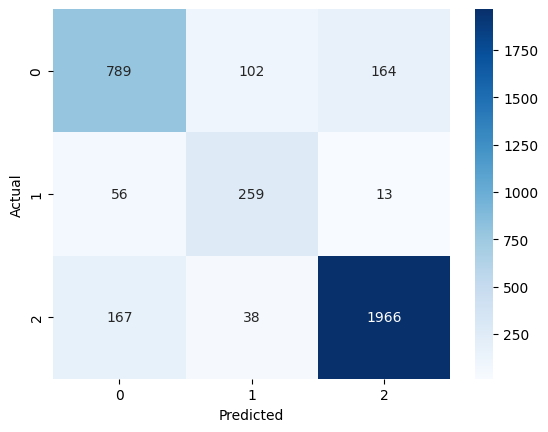

              precision    recall  f1-score   support

    negative       0.78      0.75      0.76      1055
     neutral       0.65      0.79      0.71       328
    positive       0.92      0.91      0.91      2171

    accuracy                           0.85      3554
   macro avg       0.78      0.81      0.80      3554
weighted avg       0.85      0.85      0.85      3554



In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert X_test to a NumPy array with a defined shape
X_test = X_test.astype(np.int64)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict on test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Step 12: Model Visualization

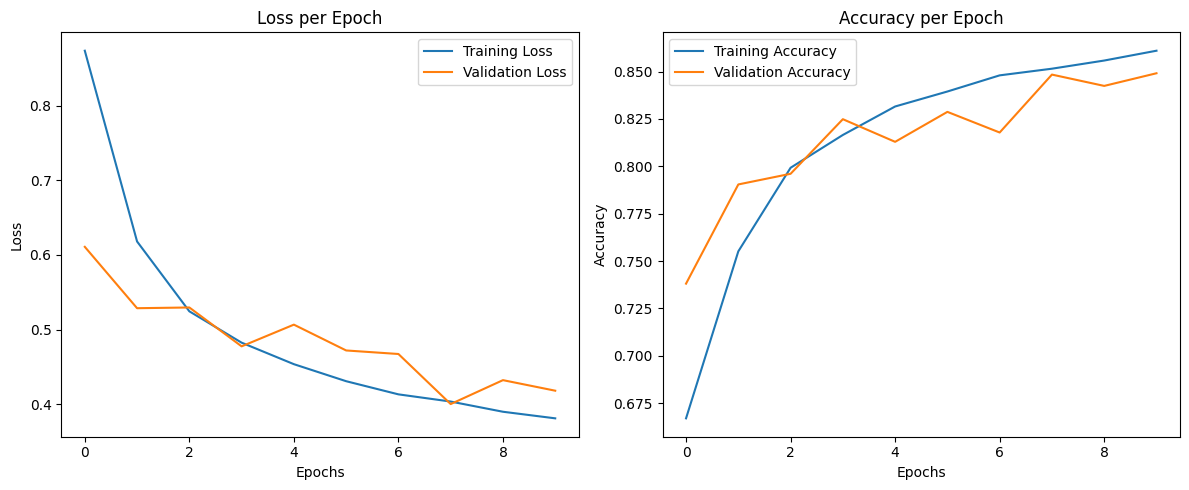

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Step 13: Test Prediction

In [32]:
def custom_sentiment_prediction(text):
    # Cleansing text
    text = cleansing_text(text)

    # Tokenize and pad text
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=100, padding='post')

    # Predict sentiment
    prediction = model.predict(padded)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])

    return predicted_label[0]

# Test examples
#texts = ["Rasa syukur, cukup", "JAHAT!!!", "Saya suka banget nasi goreng"]
#texts = ["Ya udah.. dijual lah, goblok!!!", "Yang kamu lakuin ke aku itu, JAHAT!!!", "Baiklah kalau begitu"]
texts = ["Kata hati saya: Semoga dapat jodoh yg sabar, setia, rendah hati, sehat lahir dan batin"]
#texts = ["Sayangi dirimu", "Pak ustadz nanya dong gimana klo kecanduan rokok, judi, narkoba, pinjol, mabuk, mabuk agama"]

# Display predictions
for text in texts:
    pred = custom_sentiment_prediction(text)
    print(f"Teks: {text}, Prediksi Sentimen: {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Teks: Kata hati saya: Semoga dapat jodoh yg sabar, setia, rendah hati, sehat lahir dan batin, Prediksi Sentimen: positive


Step 14: Save (Model dan Objek x_pad_sequences)

In [33]:
# Save Model
model.save('/content/drive/MyDrive/DSC25/PlatinumChallenge/model-lstm.keras')
print("Model saved successfully")

# Simpan objek ke berkas
with open('/content/drive/MyDrive/DSC25/PlatinumChallenge/tokenizer-lstm.json', 'w') as f:
    f.write(tokenizer.to_json())
    print("Tokenizer saved successfully")

Model saved successfully
Tokenizer saved successfully
